In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import (
    MinMaxScaler,
    PowerTransformer,
    RobustScaler,
)

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_curve, average_precision_score

from src.auxiliares import dataframe_coeficientes
from src.config import DADOS_TRATADOS
from src.graficos import plot_comparar_metricas_modelos, plot_coeficientes
from src.models import RANDOM_STATE
from src.models import (
    grid_search_cv_classificador,
    treinar_e_validar_modelo_classificacao,
    organiza_resultados,
    metricas_grid_search,
    construir_pipeline_modelo_classificacao
)

sns.set_theme(palette="bright")

In [2]:
df = pd.read_parquet(DADOS_TRATADOS)

df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V19,V20,V21,V23,V24,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.403993,0.251412,-0.018307,-0.110474,0.066928,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.145783,-0.069083,-0.225775,0.101288,-0.339846,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-1.232622,-0.208038,-0.108300,-0.190321,-1.175575,-0.221929,0.062723,0.061458,123.50,0
3,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.803487,0.408542,-0.009431,-0.137458,0.141267,0.502292,0.219422,0.215153,69.99,0
4,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.033194,0.084968,-0.208254,-0.026398,-0.371427,0.105915,0.253844,0.081080,3.67,0


#### Separação das colunas da Análise Exploratória

In [3]:
coluna_min_max = ["Time"]

#coluna_power_transformer = ["Amount"]

target = ["Class"]

colunas_robust_scaler = [
    coluna for coluna in df.columns if coluna not in (
        coluna_min_max  + target
    )
]

colunas_robust_scaler

['V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V14',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V23',
 'V24',
 'V26',
 'V27',
 'V28',
 'Amount']

In [4]:
X = df.drop(columns=target)
y = df[target].values.ravel()

#### Definindo Preprocessamento

In [5]:
preprocessamento = ColumnTransformer(
    transformers=[
        ("min_max", MinMaxScaler(), coluna_min_max),
        ("robust", RobustScaler(), colunas_robust_scaler),
#        ("power_transform", PowerTransformer(), coluna_power_transformer),
    ]
)

#### Definindo os Folds para validação cruzada

In [6]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

#### Dicionário de Classificadores

In [7]:
scale_pos_weight = np.bincount(y)[0] / np.bincount(y)[1]
scale_pos_weight

520.5040650406504

In [8]:
classificadores = {
    "DummyClassifier": {
        "preprocessor": None,
        "classificador": DummyClassifier(strategy="stratified"),
    },
    "LogisticRegression": {
        "preprocessor": preprocessamento,
        "classificador": LogisticRegression(class_weight="balanced"),
    },
    "DecisionTreeClassifier": {
        "preprocessor": None,
        "classificador": DecisionTreeClassifier(class_weight="balanced"),
    },
    "LGBMClassifier": {
        "preprocessor": None,
        "classificador": LGBMClassifier(
            random_state=RANDOM_STATE,
            n_jobs=-1,
            verbose=-1,
            scale_pos_weight=scale_pos_weight,
        ),
    },
    "XGBClassifier": {
        "preprocessor": None,
        "classificador": XGBClassifier(
            random_state=RANDOM_STATE, n_jobs=-1, scale_pos_weight=scale_pos_weight
        ),
    },
    # "SVC": {                                                               OBS: Deixando comentado porque esses modelo são muito lentos com grandes volumes de dados
    #     "preprocessor": preprocessamento,
    #     "classificador": SVC(class_weight="balanced", cache_size=1000),
    # },
    #"KNeighborsClassifier": {                                               OBS: Deixando comentado porque esses modelo são muito lentos com grandes volumes de dados
    #    "preprocessor": preprocessamento,
    #    "classificador": KNeighborsClassifier(),
    #},
}

#### Treinando e Testando Modelos de Classificação

In [9]:
resultados = {
    nome_modelo: treinar_e_validar_modelo_classificacao(X, y, kf, **classificador)
    for nome_modelo, classificador in classificadores.items()
}

df_resultados = organiza_resultados(resultados)

df_resultados

,model,fit_time,score_time,test_accuracy,test_balanced_accuracy,test_f1,test_precision,test_recall,test_roc_auc,test_average_precision,time_seconds
0,DummyClassifier,0.111728,0.149924,0.99622,0.499063,0.0,0.0,0.0,0.499034,0.00191,0.261652
1,DummyClassifier,0.10459,0.166389,0.996258,0.499082,0.0,0.0,0.0,0.50395,0.001976,0.270978
2,DummyClassifier,0.115606,0.148677,0.996531,0.499219,0.0,0.0,0.0,0.498916,0.00191,0.264282
3,DummyClassifier,0.087916,0.245382,0.996122,0.504065,0.00995,0.009804,0.010101,0.49917,0.001929,0.333298
4,DummyClassifier,0.11705,0.150182,0.996161,0.499043,0.0,0.0,0.0,0.499043,0.001929,0.267231
5,LogisticRegression,2.366152,0.266017,0.984683,0.936312,0.18125,0.100928,0.887755,0.98695,0.695417,2.632169
6,LogisticRegression,2.581792,0.249737,0.979733,0.954201,0.148936,0.080961,0.928571,0.981089,0.811656,2.831529
7,LogisticRegression,2.441453,0.250931,0.978603,0.953635,0.142187,0.076988,0.928571,0.980641,0.866498,2.692384
8,LogisticRegression,2.110546,0.262776,0.982052,0.945642,0.163488,0.08982,0.909091,0.976198,0.735507,2.373322
9,LogisticRegression,1.882739,0.252708,0.980201,0.954796,0.153333,0.08356,0.929293,0.983649,0.755838,2.135447


**Qual métrica vamos escolher para a melhor para esse contexto?**
- Contexto: Queremos conseguir identificar as fraudes de um cartão de crédito
- Nessa aplicação é pior não detectar um frande de um cartão do que detectar uma transação verdadeira como fraude, pois podemos ter algum método de verificação com o cliente antes de alguma compra suspeita
- Portanto, para esse problema o recall é mais importante que a precisão.
- Mas focar somente no recall pode trazer modelos que apontam tudo como fraude, o que é ruim também.
- Métricas como average_precision, que é a área de baixo da curva Precision-Recall, fazem um balanceamento entre os dados de recall e precisão e podem ser mais úteis nesse contexto.

In [10]:
df_resultados.groupby("model").mean().sort_values("test_average_precision")

,fit_time,score_time,test_accuracy,test_balanced_accuracy,test_f1,test_precision,test_recall,test_roc_auc,test_average_precision,time_seconds
model,,,,,,,,,,
DummyClassifier,0.107378,0.17211,0.996258,0.500094,0.00199,0.001961,0.00202,0.500023,0.001931,0.279488
LGBMClassifier,2.884412,0.304434,0.921144,0.890573,0.050796,0.026463,0.859885,0.884299,0.023549,3.188846
DecisionTreeClassifier,22.52199,0.199556,0.999178,0.880903,0.780424,0.800336,0.762173,0.880903,0.610352,22.721546
LogisticRegression,2.276537,0.256434,0.981055,0.948917,0.157839,0.086452,0.916656,0.981705,0.772983,2.53297
XGBClassifier,3.067188,0.313958,0.999622,0.923736,0.895317,0.949773,0.847557,0.986293,0.889975,3.381146


**Análise dos Resultados**
- Melhor modelo: XGBClassifier (nenhum outro modelo apresentou resultados semelhantes) considerando o 'average_precision'
- Além de bons resultados da average_precision, outras métricas parecem ser muito boas também (recall, precision, roc_auc)

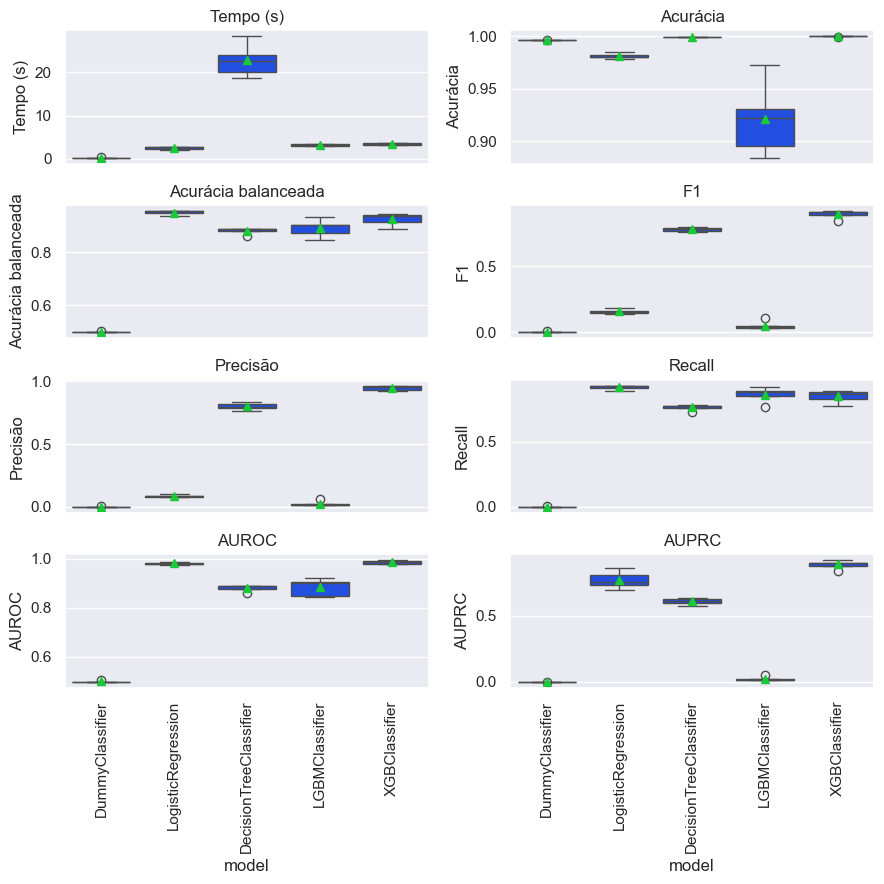

In [11]:
plot_comparar_metricas_modelos(df_resultados)

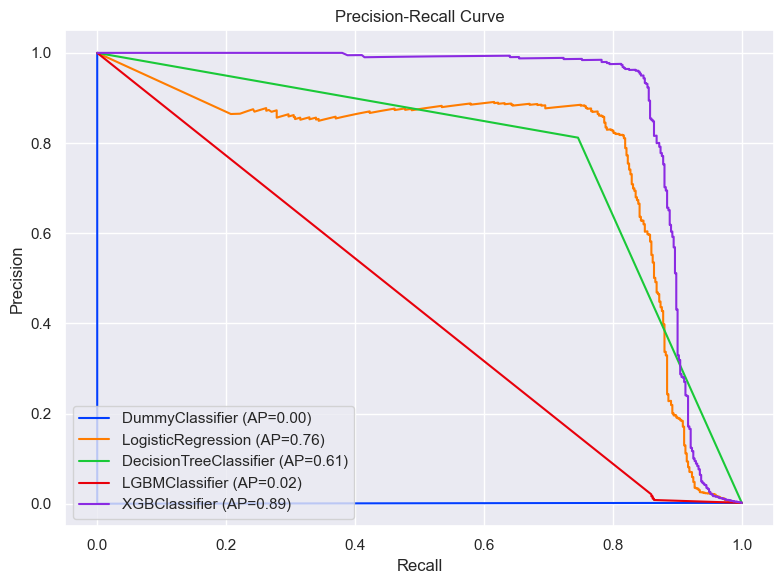

In [ ]:
def obter_probabilidades_com_cross_val_predict(X, y, cv, classificador, preprocessor=None, sampler=None):
    modelo = construir_pipeline_modelo_classificacao(classificador, preprocessor, sampler)
    y_proba = cross_val_predict(modelo, X, y, cv=cv, method='predict_proba')[:, 1]
    return y, y_proba

plt.figure(figsize=(8, 6))

for nome_modelo, config in classificadores.items():
    y_true, y_proba = obter_probabilidades_com_cross_val_predict(
        X, y, kf,
        classificador=config["classificador"],
        preprocessor=config["preprocessor"]
    )
    
    precision, recall, _ = precision_recall_curve(y_true, y_proba)
    ap = average_precision_score(y_true, y_proba)
    
    plt.plot(recall, precision, label=f"{nome_modelo} (AP={ap:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="lower left")
plt.grid(True)
plt.tight_layout()
plt.show()


In [12]:
classificadores["XGBClassifier"]

{'preprocessor': None,
 'classificador': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               feature_weights=None, gamma=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=None, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, multi_strategy=None, n_estimators=None,
               n_jobs=-1, num_parallel_tree=None, ...)}

In [17]:
# Podemos treinar_e_validar_modelo de um modelo por vez também

treinar_e_validar_modelo_classificacao(
    X, y, kf, **classificadores["XGBClassifier"]
)

{'fit_time': array([1.51612043, 1.41616392, 1.58912826, 1.86667252, 1.93451452]),
 'score_time': array([0.11356282, 0.11664724, 0.16201901, 0.14853859, 0.12750173]),
 'test_accuracy': array([0.99945436, 0.99966872, 0.99970769, 0.99961026, 0.99966872]),
 'test_balanced_accuracy': array([0.88769653, 0.94381898, 0.93874622, 0.91411213, 0.93430438]),
 'test_f1': array([0.84444444, 0.91099476, 0.9197861 , 0.89130435, 0.91005291]),
 'test_precision': array([0.92682927, 0.93548387, 0.96629213, 0.96470588, 0.95555556]),
 'test_recall': array([0.7755102 , 0.8877551 , 0.87755102, 0.82828283, 0.86868687]),
 'test_roc_auc': array([0.97754795, 0.99096101, 0.98851886, 0.97993978, 0.99449895]),
 'test_average_precision': array([0.84433049, 0.90305055, 0.89986844, 0.88100103, 0.92162321])}

#### Eliminando features do modelo

Uma vez que agora não foi utilizado o método de balanceamento de classes como RandomUnderSampler, que reduz o tamanho da base, seria interessante entender quais features tem menor relevância para o modelo e eliminá-las da base antes da busca pela otimização de parâmetros do GridSearch 

Métodos conhecidos:
- Métodos Estatísticos (como foi feito na análise exploratória)
- Feature Selection: SelectKBest
- Permutation Importance: embaralha os dados de uma feature, se o resultado do modelo mudar muito, quer dizer que essa feature é muito importante

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE, stratify=y)

In [15]:
clf = classificadores['XGBClassifier']['classificador']     # Pegando o classificador do dicionário de classificadores acima

clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=-1, num_parallel_tree=None, ...)

In [16]:
perm_imp = permutation_importance(
    clf,
    X_test,
    y_test,
    n_repeats=10,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    scoring='average_precision'
)

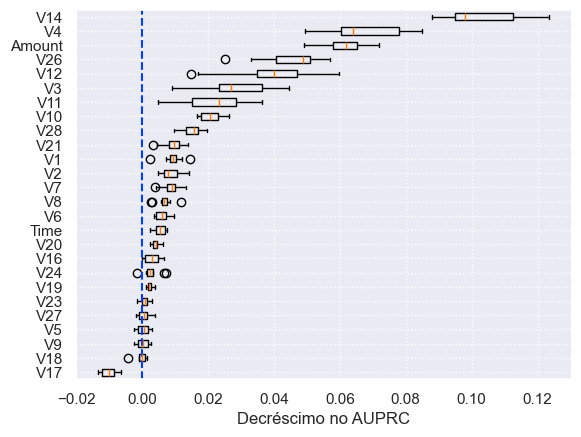

In [17]:
fig, ax = plt.subplots()

ordem = perm_imp.importances_mean.argsort()

ax.boxplot(perm_imp.importances[ordem].T, vert=False, tick_labels=X.columns[ordem])

ax.axvline(x=0, linestyle='--')
ax.set_xlabel('Decréscimo no AUPRC')
ax.grid(True, linestyle=":")

plt.show()


In [18]:
perm_imp.importances_mean

array([ 0.00527042,  0.00928424,  0.00870414,  0.02871306,  0.06841606,
        0.00044666,  0.00616417,  0.00869138,  0.00665531,  0.00021158,
        0.0207063 ,  0.02268825,  0.03889337,  0.10351298,  0.00300705,
       -0.01019586, -0.00024938,  0.00235822,  0.00421469,  0.00933825,
        0.00068464,  0.00278895,  0.04534865,  0.0005824 ,  0.01521219,
        0.06118491])

In [19]:
X.columns[perm_imp.importances_mean < 0.01]          # Podemos elimnar essas colunas do nosso dataframe

Index(['Time', 'V1', 'V2', 'V5', 'V6', 'V7', 'V8', 'V9', 'V16', 'V17', 'V18',
       'V19', 'V20', 'V21', 'V23', 'V24', 'V27'],
      dtype='object')

In [20]:
X_new = X.drop(columns=X.columns[perm_imp.importances_mean < 0.01])

X_new.columns

Index(['V3', 'V4', 'V10', 'V11', 'V12', 'V14', 'V26', 'V28', 'Amount'], dtype='object')

#### Rodando o modelo XGBClassifier novamente com menos features e comparando resultados com a base anterior

In [21]:
# Base com features iniciais pelo permutation_importance

treinar_e_validar_modelo_classificacao(
    X, y, kf, **classificadores["XGBClassifier"]
)

{'fit_time': array([2.12955785, 1.71520543, 1.74956298, 1.86692595, 3.17484188]),
 'score_time': array([0.14402604, 0.13942146, 0.13037133, 0.2186048 , 0.18985677]),
 'test_accuracy': array([0.99945436, 0.99966872, 0.99970769, 0.99961026, 0.99966872]),
 'test_balanced_accuracy': array([0.88769653, 0.94381898, 0.93874622, 0.91411213, 0.93430438]),
 'test_f1': array([0.84444444, 0.91099476, 0.9197861 , 0.89130435, 0.91005291]),
 'test_precision': array([0.92682927, 0.93548387, 0.96629213, 0.96470588, 0.95555556]),
 'test_recall': array([0.7755102 , 0.8877551 , 0.87755102, 0.82828283, 0.86868687]),
 'test_roc_auc': array([0.97754795, 0.99096101, 0.98851886, 0.97993978, 0.99449895]),
 'test_average_precision': array([0.84433049, 0.90305055, 0.89986844, 0.88100103, 0.92162321])}

In [22]:
# Base sem as features removidas 

treinar_e_validar_modelo_classificacao(
    X_new, y, kf, **classificadores["XGBClassifier"]
)

{'fit_time': array([1.16413164, 1.29622245, 1.04291987, 1.29328656, 1.27489448]),
 'score_time': array([0.18820095, 0.18049288, 0.1545496 , 0.20265889, 0.19956231]),
 'test_accuracy': array([0.99941539, 0.99962975, 0.99951282, 0.99953231, 0.99949334]),
 'test_balanced_accuracy': array([0.88258473, 0.93870717, 0.91827949, 0.91911382, 0.92413504]),
 'test_f1': array([0.83333333, 0.90052356, 0.86772487, 0.87368421, 0.86597938]),
 'test_precision': array([0.91463415, 0.92473118, 0.9010989 , 0.91208791, 0.88421053]),
 'test_recall': array([0.76530612, 0.87755102, 0.83673469, 0.83838384, 0.84848485]),
 'test_roc_auc': array([0.97385246, 0.97489323, 0.98426693, 0.97711579, 0.9926295 ]),
 'test_average_precision': array([0.82628555, 0.88727911, 0.88560336, 0.87943563, 0.88295909])}

Veja que os dados estão bem parecidos, ou seja, removemos essas features e o modelo continua apresendo bons resultados

#### Testando diferentes parâmetros no melhor modelo

In [23]:
param_grid = {
    "clf__max_depth": [3, 6, 10],                      # Profundidade da árvore
    # "clf__min_child_weight": [1, 3, 5],              # Peso mínimo de uma folha
    # "clf__gamma": [0, 0.1, 0.3],                     # Redução mínima de perda para uma divisão
    "clf__subsample": [0.75, 1.0],                     # Proporção de amostras usadas para cada árvore
    "clf__colsample_bytree": [0.75, 1.0],              # Proporção de features para cada árvore
    # "clf__learning_rate": [0.1, 0.3, 0.5],           # Taxa de aprendizado
    # "clf__n_estimators": [10, 50, 100],              # Número de árvores
    "clf__reg_lambda": [1, 2, 5],                      # Regularização L2 
    "clf__reg_alpha": [0, 0.5, 1],                     # Regularização L1
    # "clf__scale_pos_weight": [1, scale_pos_weight],  # Peso das classes (já estará no modelo abaixo)
}

#### Otimizando o modelo com a GriSearchCV nesse dataframe com menos features

In [24]:
clf = XGBClassifier(random_state=RANDOM_STATE, n_jobs=-1, scale_pos_weight = scale_pos_weight)

grid_search = grid_search_cv_classificador(
    clf,
    param_grid,
    kf,
    preprocessor=None, 
    refit_metric='average_precision'
)

grid_search

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('clf',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      feature_weights=Non...
                                                      n_estimators=None,
                                                      n_jobs=-1,
                                                      num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'clf__colsample_bytree': [0.75, 1.0],
                         'clf__max_depth': [3, 6, 10],
                         'clf__reg_alpha': [0, 0.5, 1],
                         'clf__reg_lambda': [1, 2, 5],
                         'clf__subsample': [0.75, 1.0]},
             refit='average_precision',
             scoring=['accuracy', 'balanced_accuracy', 'f1', 'precision',
                      'recall', 'roc_auc', 'average_precision'],
             verbose=1)

In [25]:
grid_search.fit(X_new, y)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('clf',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      feature_weights=Non...
                                                      n_estimators=None,
                                                      n_jobs=-1,
                                                      num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'clf__colsample_bytree': [0.75, 1.0],
                         'clf__max_depth': [3, 6, 10],
                         'clf__reg_alpha': [0, 0.5, 1],
                         'clf__reg_lambda': [1, 2, 5],
                         'clf__subsample': [0.75, 1.0]},
             refit='average_precision',
             scoring=['accuracy', 'balanced_accuracy', 'f1', 'precision',
                      'recall', 'roc_auc', 'average_precision'],
             verbose=1)

In [26]:
grid_search.best_params_

{'clf__colsample_bytree': 1.0,
 'clf__max_depth': 10,
 'clf__reg_alpha': 0,
 'clf__reg_lambda': 2,
 'clf__subsample': 1.0}

In [27]:
grid_search.best_score_

0.8785959722516161

#### Obtendo as Outras Métricas do grid_search.best_estimator

In [33]:
metricas_grid_search(grid_search)

# OBS: Recall manteve-se em 93%

mean_fit_time: 8.76540846824646
mean_score_time: 1.3279440879821778
mean_test_accuracy: 0.9995089250915894
mean_test_balanced_accuracy: 0.9186073630546913
mean_test_f1: 0.8671021323816787
mean_test_precision: 0.8999639396686929
mean_test_recall: 0.8373943516800659
mean_test_roc_auc: 0.9812328116763946
mean_test_average_precision: 0.8785959722516161


Veja que o score do average_precision passou de 0.88 do modelo original para 0.87, resultado reduziu um pouco mas nada significativo com a redução dos dados e o ganho de tempo que tivemos.

#### Analisando as features de maior importância pro modelo

*Métodos que serão utilizados:*
- Plot Importance: com parametros 'weight''
- Plot Importance: com parametros 'gain'

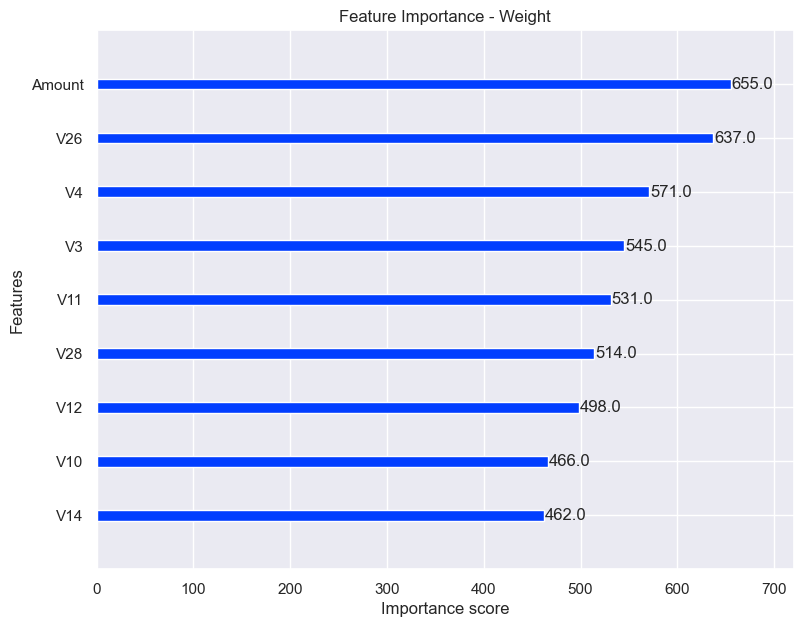

In [34]:
fig, ax = plt.subplots(figsize=(9,7))

plot_importance(
    grid_search.best_estimator_['clf'],
    ax=ax,
    importance_type = 'weight',
    title = "Feature Importance - Weight"
)

plt.show()

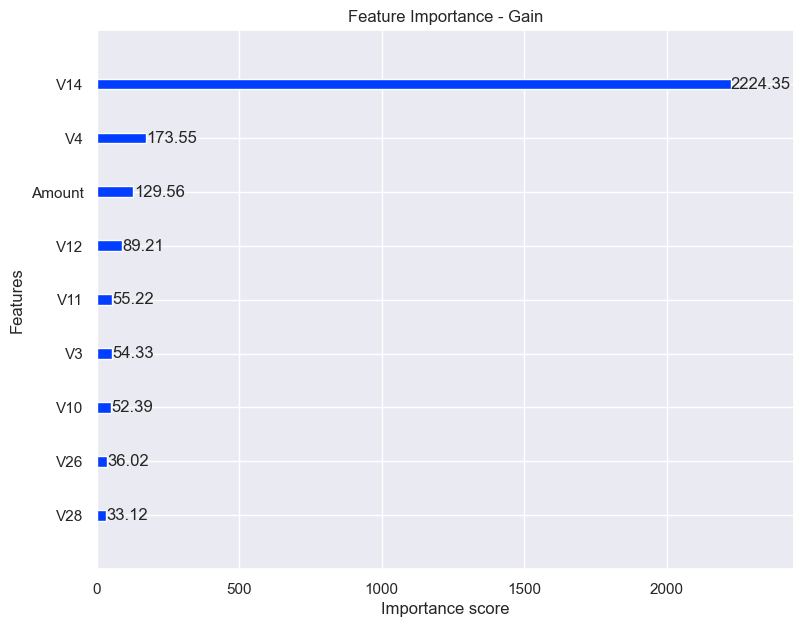

In [35]:
fig, ax = plt.subplots(figsize=(9,7))

plot_importance(
    grid_search.best_estimator_['clf'],
    ax=ax,
    importance_type = 'gain',
    title = "Feature Importance - Gain",
    values_format = "{v:.2f}"
)

plt.show()

#### Matriz de Confusão

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

In [22]:
classificadores["XGBClassifier"]['classificador'].fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=-1, num_parallel_tree=None, ...)

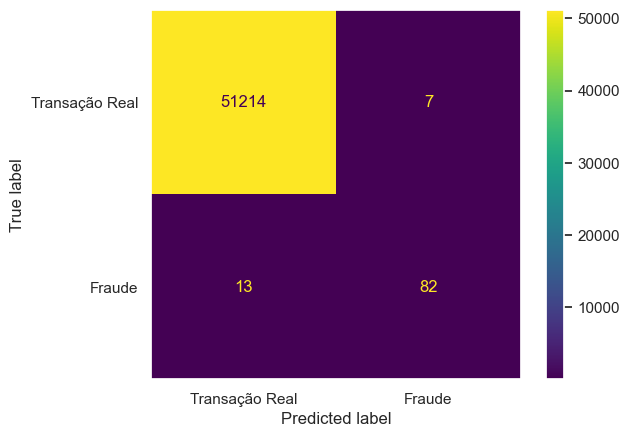

In [23]:
ConfusionMatrixDisplay.from_estimator(
    classificadores["XGBClassifier"]['classificador'],
    X_test,
    y_test,
    display_labels = ['Transação Real', 'Fraude']
)

plt.grid(False)
plt.show()

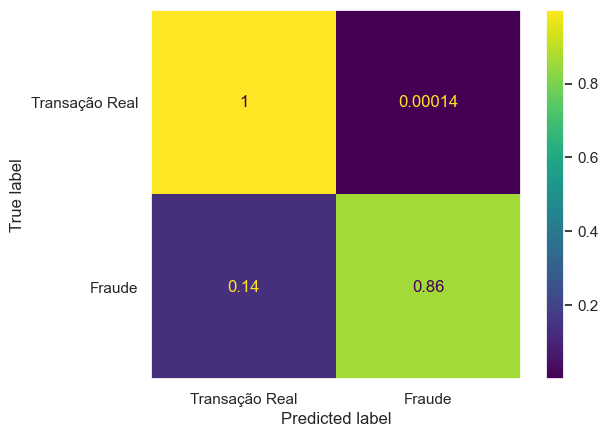

In [24]:
ConfusionMatrixDisplay.from_estimator(
    classificadores["XGBClassifier"]['classificador'],
    X_test,
    y_test,
    display_labels = ['Transação Real', 'Fraude'],
    normalize='true'
)

plt.grid(False)
plt.show()

##### **Conclusões**
- Não sabemos o que cada feature representa, mas ao utilizar 3 métodos para analisar as features de maior importância vemos que as colunas "V14, V4," e o valor da transação "Amount" se repetem demonstrando uma influência maior na detecção de fraudes do cartão de crédito.